In [1]:
import _pickle as pickle
import jax
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from jaxl.constants import *
from jaxl.plot_utils import set_size

In [2]:
doc_width_pt = 750.0
baseline_path = "/home/bryanpu1/projects/jaxl/scripts/icl/results-num_blocks_8-num_tasks_5-seq_len_16-seed_9999-10-11-23_20_07_56"

context_data = pickle.load(
    open(os.path.join(baseline_path, "context_data.pkl"), "rb")
)

gt = pickle.load(
    open(os.path.join(baseline_path, "ground_truth.pkl"), "rb")
)

agent_reprs = pickle.load(
    open(os.path.join(baseline_path, "agent_reprs.pkl"), "rb")
)

agent_results = pickle.load(
    open(os.path.join(baseline_path, "agents.pkl"), "rb")
)

config = pickle.load(
    open(os.path.join(baseline_path, "config.pkl"), "rb")
)

baseline_results = pickle.load(
    open(os.path.join(baseline_path, "baseline_results.pkl"), "rb")
)

input_range = config["input_range"]

# Visualize ICL Transformer

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


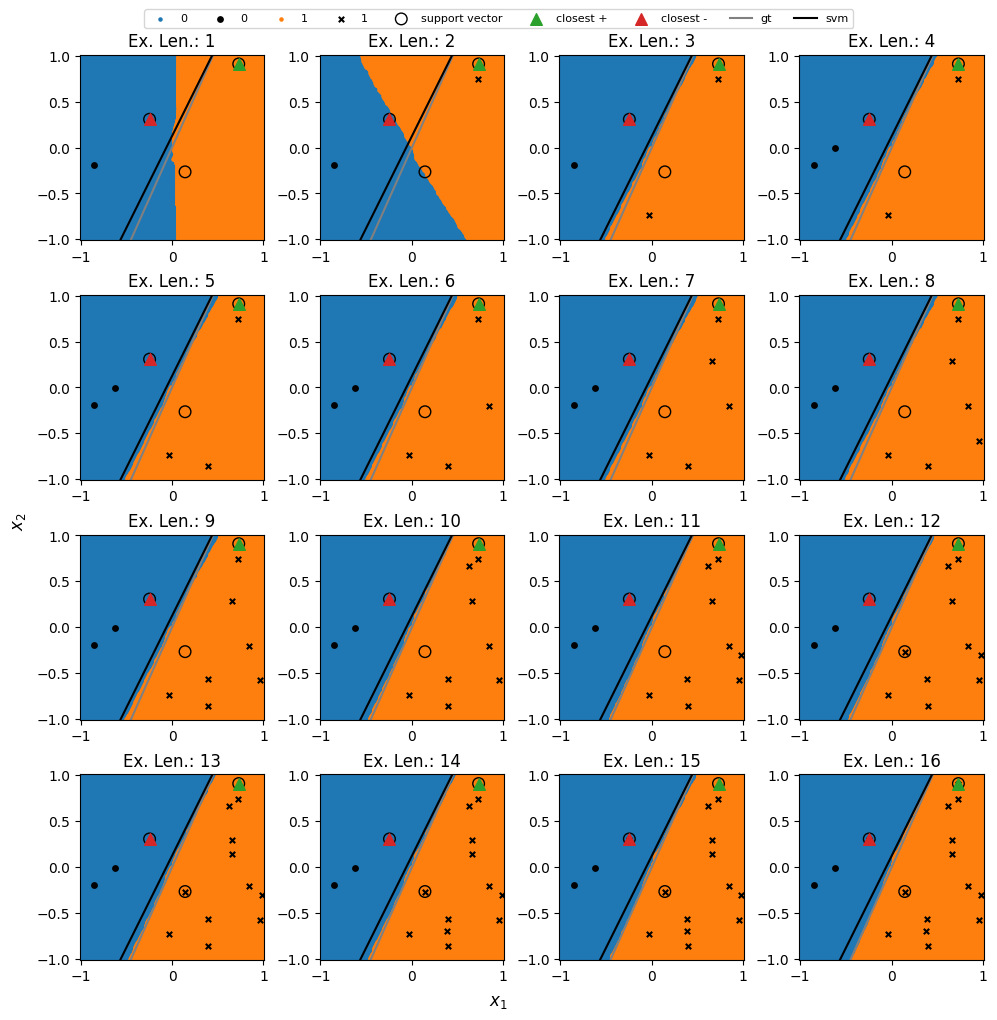

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


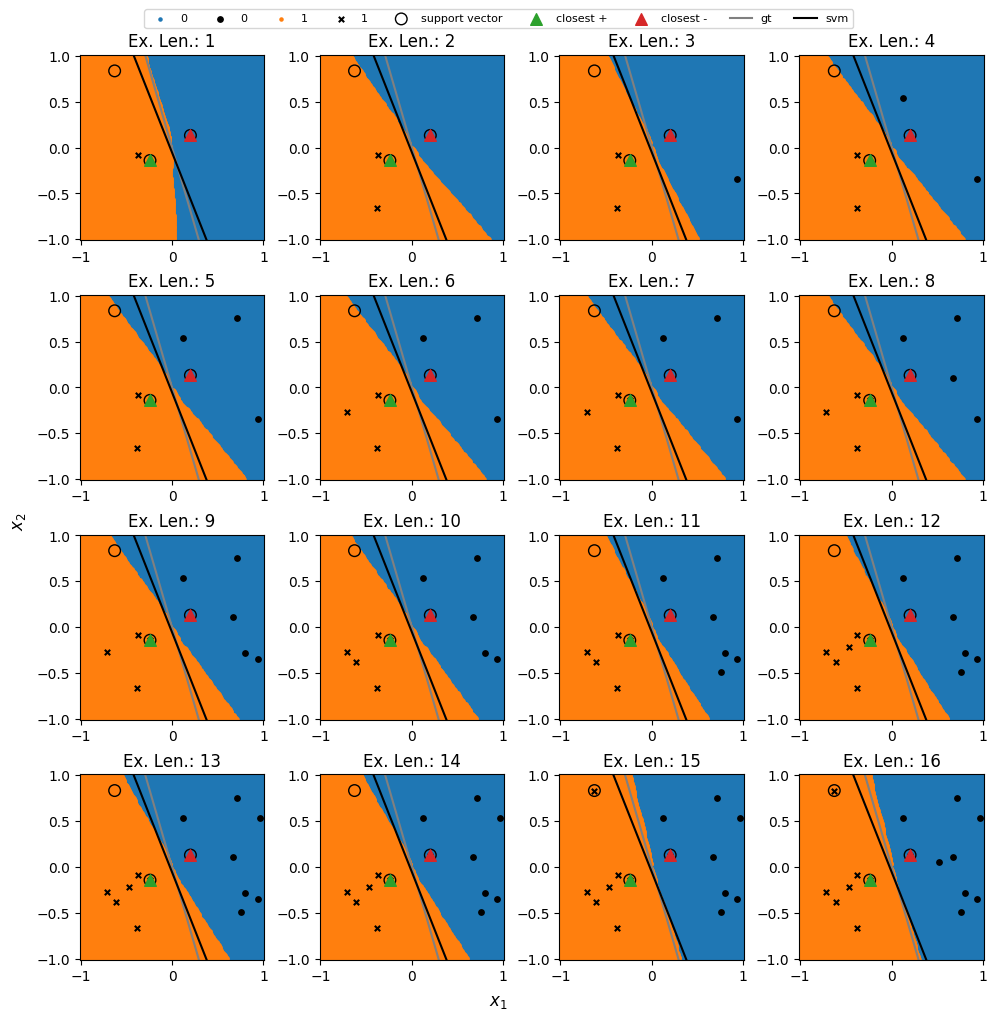

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


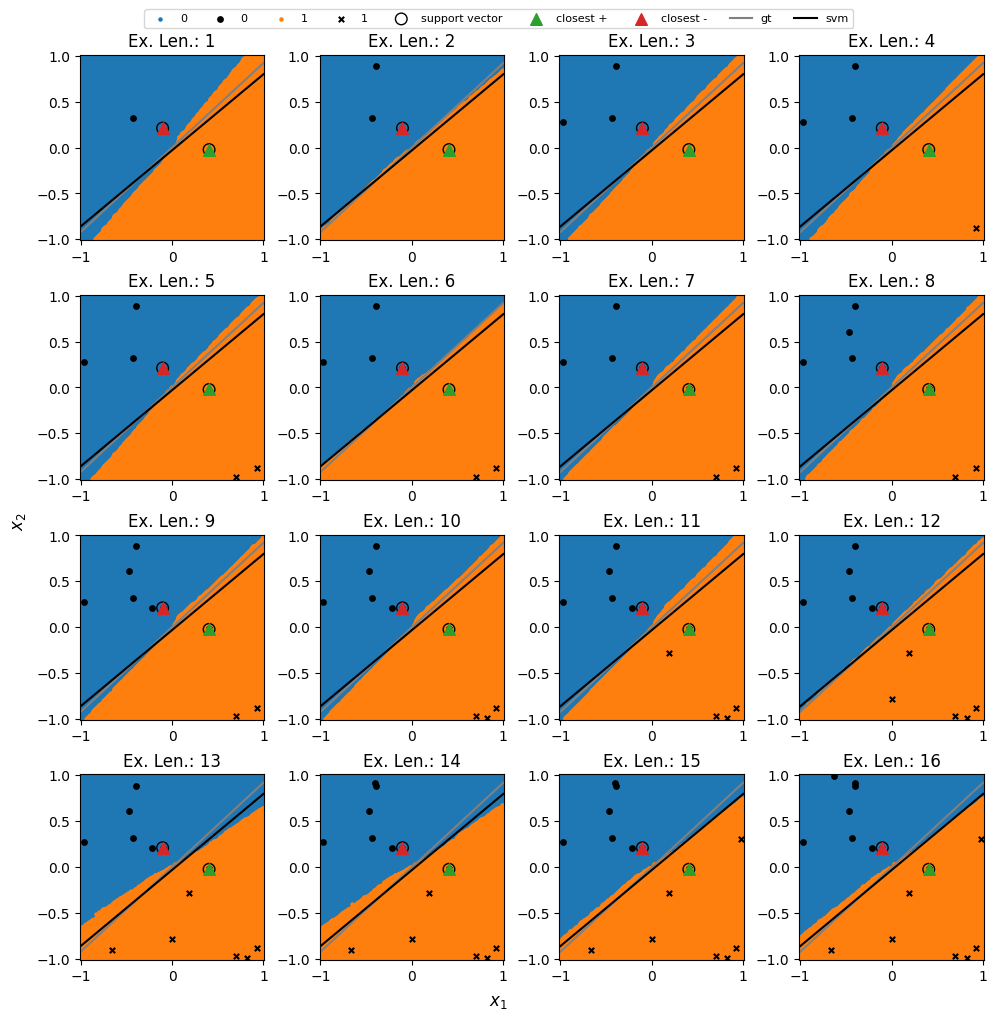

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


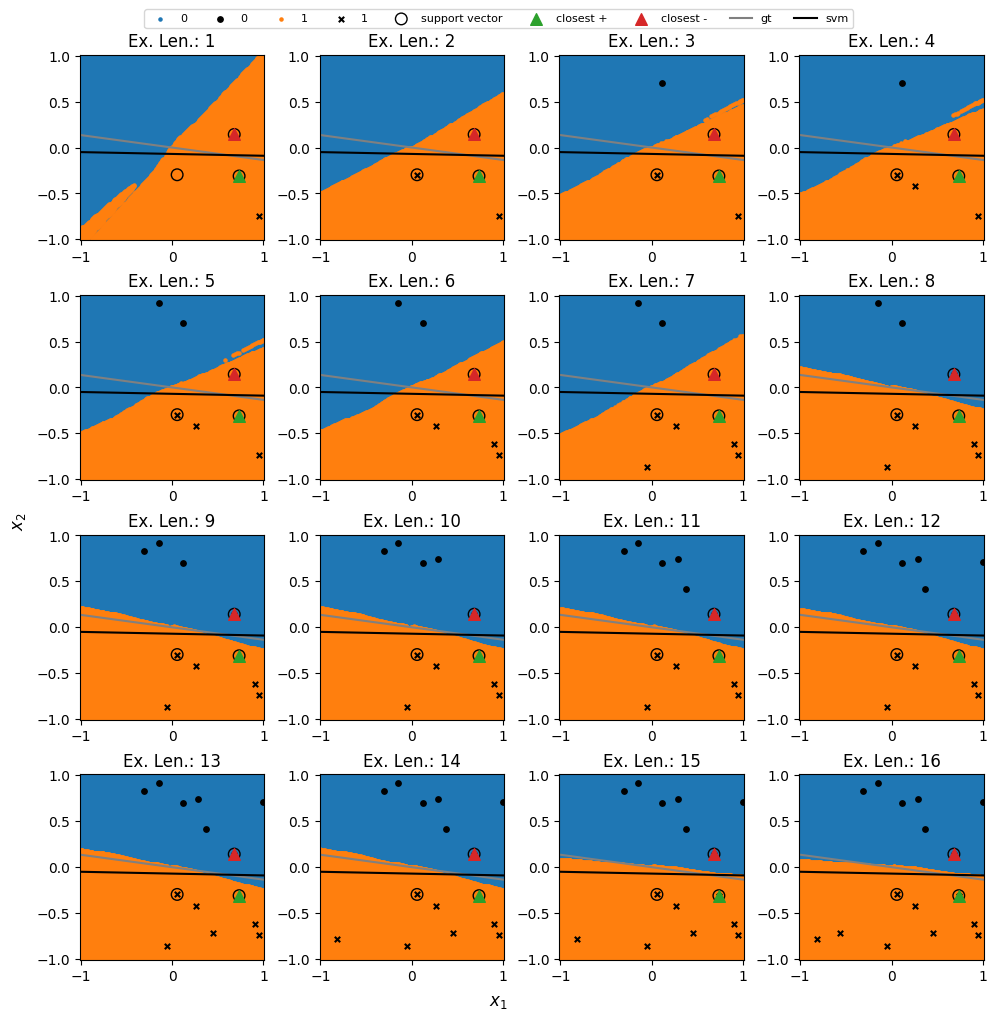

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


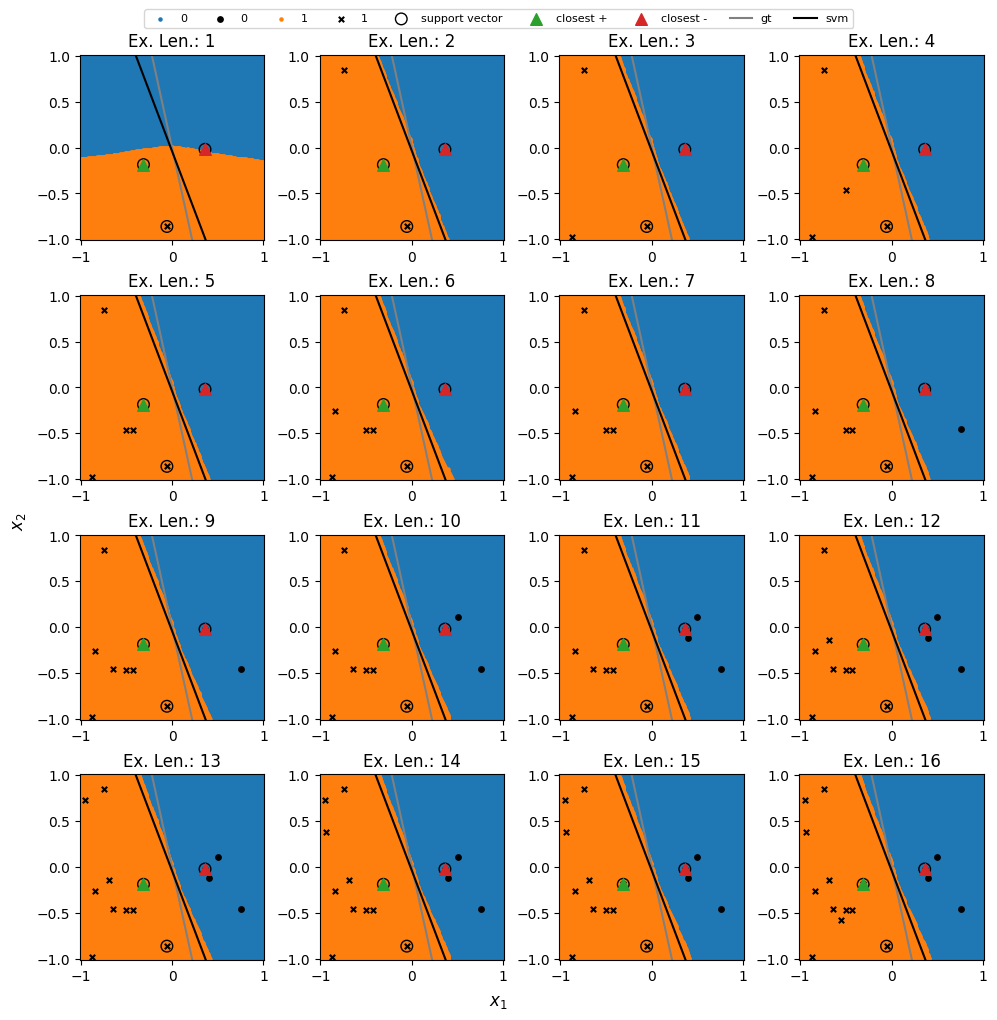

In [26]:
ncols = 4
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_result in agent_results.items():
        print("Processing agent {}".format(agent_path))

        svm_primal = agent_reprs[agent_path]["svms"][task_i]["input"]["primal"]["sol"]
        svm_db = -(np.array(input_range) * svm_primal[0] + svm_primal[2]) / svm_primal[1]

        primal_out = (context_inputs @ svm_primal[:-1]) + svm_primal[-1]
        primal_constraints = 2 * (0.5 - (1 - train_y)) * primal_out
        support_vectors = context_inputs[np.where(primal_constraints <= 1)[0]]

        poss = np.where(primal_out > 0)[0]
        negs = np.where(primal_out < 0)[0]
        closest_pos = context_inputs[poss[np.argmin(primal_out[poss])]]
        closest_neg = context_inputs[negs[np.argmax(primal_out[negs])]]

        per_task_results = agent_result[task_i]
        nrows = math.ceil(len(per_task_results) / ncols)
        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        
        for ax_i, examplar_len in enumerate(per_task_results):
            mask = (np.arange(len(context_inputs)) >= len(context_inputs) - examplar_len)
            if nrows == 1:
                ax = axes[ax_i]
            else:
                ax = axes[ax_i // ncols, ax_i % ncols]
            one_hot_preds = per_task_results[examplar_len]
            preds = np.argmax(one_hot_preds, axis=-1)
            
            for possible_label in [0, 1]:
                idxes = np.where(preds == possible_label)
                ax.scatter(
                    gt["inputs"][idxes][:, 0],
                    gt["inputs"][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=5,
                )
                idxes = np.where(train_y[mask] == possible_label)
                ax.scatter(
                    context_inputs[mask][idxes][:, 0],
                    context_inputs[mask][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=15,
                    marker="x" if possible_label else "o",
                    c="black"
                )

            ax.scatter(
                support_vectors[:, 0],
                support_vectors[:, 1],
                label=f"support vector" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="black",
            )

            ax.scatter(
                closest_pos[0],
                closest_pos[1],
                label=f"closest +" if ax_i == 0 else "",
                s=70,
                marker="^"
            )

            ax.scatter(
                closest_neg[0],
                closest_neg[1],
                label=f"closest -" if ax_i == 0 else "",
                s=70,
                marker="^"
            )
            
            ax.plot(
                input_range,
                gt["decision_boundary"][task_i],
                color="gray",
                label="gt" if ax_i == 0 else ""
            )
            ax.plot(
                input_range,
                svm_db,
                color="black",
                label="svm" if ax_i == 0 else ""
            )
            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title("Ex. Len.: {}".format(examplar_len))

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=10,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Visualize Representation SVM
Visualize SVM trained in the represnetation space induced by the transformer by mapping the SVM prediction back onto the input space.
- `context_reprs` corresponds to the representation induced by feeding in each of the context samples into the query token
- `input_token_context_reprs` corresponds to taking the context token directly

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[ 1.00472674 -1.          1.07815205  1.08676046  1.          1.07953459
  1.04701082  1.06693504  1.08521378  1.07766353  1.07719749  1.07916507
 -1.01064237  1.          1.05062195 -1.00453614]
[ 1.         -1.          2.01125914  3.46520972  1.65278657  2.30851272
  2.07588089  2.23796618  2.31468016  2.15730969  2.11327211  2.16322834
 -1.          1.          1.98825819 -1.22207787]


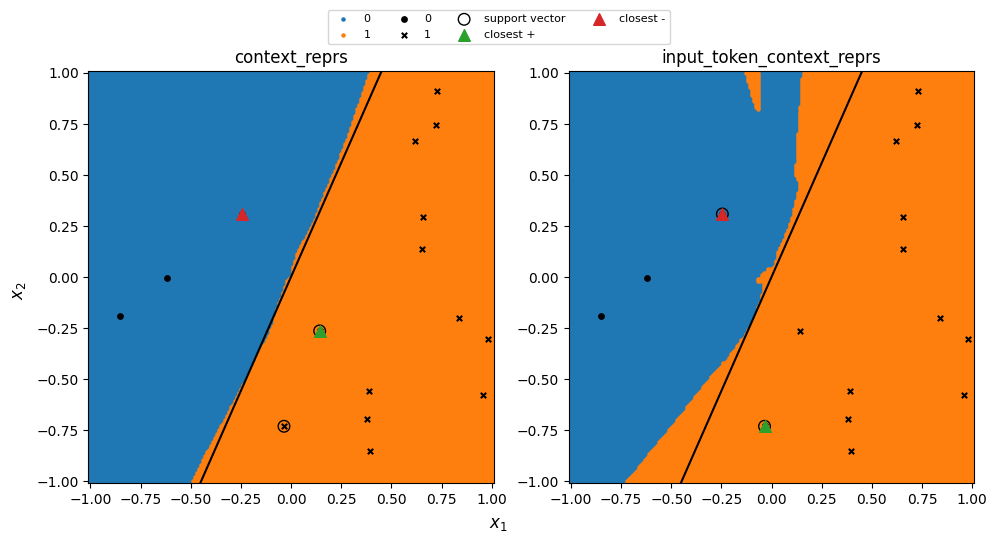

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[ -1.           5.85268697 -19.53278852  -1.           1.
  -1.           1.03857879  -1.          -3.2002965    1.
   1.         -26.4812558   -4.82990556  -9.21890018   1.
   1.        ]
[-1.          1.         -4.9106628  -5.80391892  5.33609542 -5.55657958
  5.27842435 -6.2089619  -6.09211926  5.05920586  5.45181209 -5.70704731
 -1.         -6.184964    4.68263585  5.43218951]


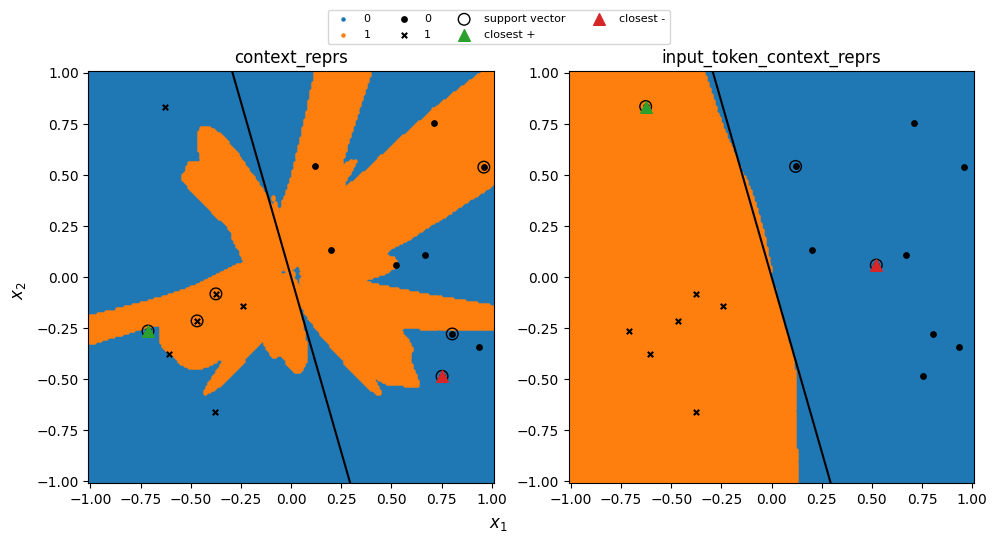

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[-1.         11.39883718 -1.          1.          1.          1.
  1.         -2.28362949 -1.          1.         -1.          1.
  1.         -1.         -1.90242994 -1.        ]
[-1.          1.         -1.02014722  1.          1.          1.17600244
  1.55355057 -1.16962671 -1.24265756  1.55803452 -1.          1.49002875
  1.45998605 -1.49399514 -1.30979026 -1.36650609]


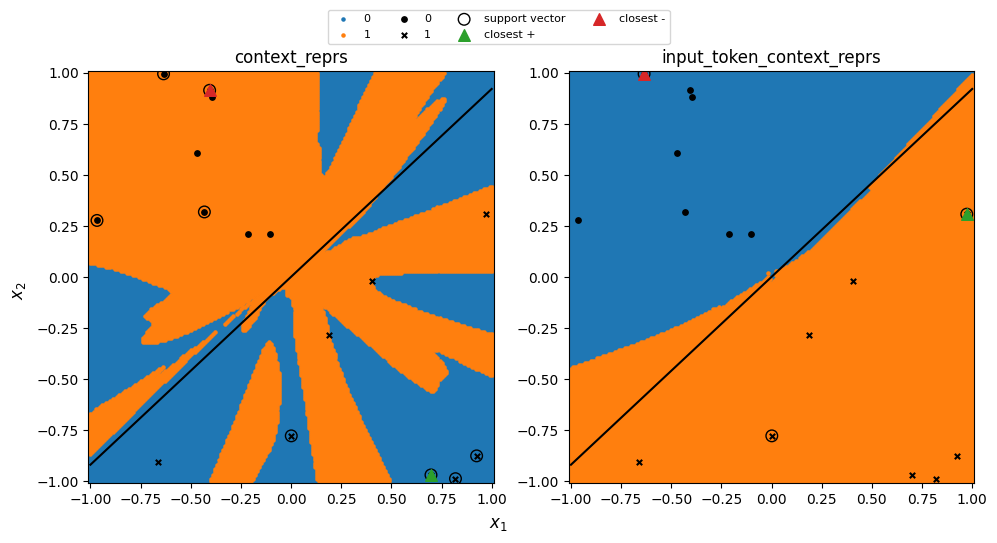

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[  1.           1.           1.           1.         -14.4770074
  -1.          -1.          -1.          -5.59244741   4.35507839
   7.39848411  -1.           7.39227706  -3.04695524   1.
   8.46421928]
[ 1.          1.          4.17927011  2.71390581 -1.23578518 -1.36852622
 -1.95625476 -1.39420875 -1.          3.94396611  2.86690754 -1.91882914
  3.44375549 -1.70123217  3.87981374  2.6568258 ]


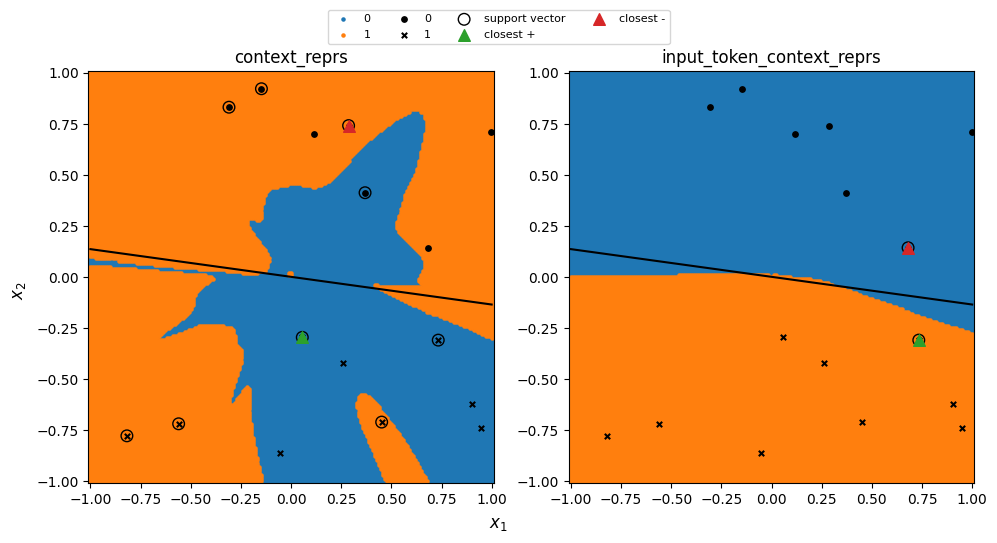

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[  1.         340.19103163 123.69547652   1.           3.42131406
  -1.          -1.           1.          -5.42070152  -1.
   1.         171.80328335 343.19539694 332.2591804    1.
 348.59771957]
[ 1.          2.22604829  1.21872118  1.9206801   2.35669654 -1.
 -1.00985052  2.31235208 -1.         -1.00951615  2.36439679  2.25948717
  2.31825073  2.28992172  1.76432056  1.02919581]


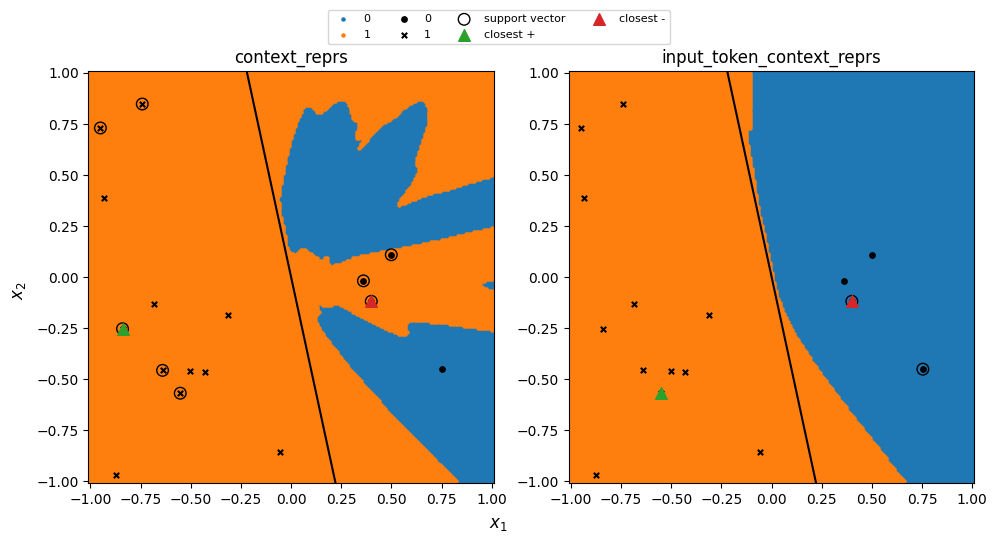

In [27]:
nrows = 1
ncols = 2
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():
        print("Processing agent {}".format(agent_path))

        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        query_input = agent_repr["query_reprs"][task_i]
        for ax_i, repr_key in enumerate(["context_reprs", "input_token_context_reprs"]):

            svm_primal = agent_reprs[agent_path]["svms"][task_i][repr_key]["primal"]["sol"]
            svm_db = -(np.array(input_range) * svm_primal[0] + svm_primal[2]) / svm_primal[1]

            primal_out = (np.array(agent_repr[repr_key][task_i]) @ svm_primal[:-1]) + svm_primal[-1]
            primal_constraints = 2 * (0.5 - (1 - train_y)) * primal_out
            print(primal_out)
            support_vectors = context_inputs[np.where(primal_constraints <= 1)[0]]
            
            poss = np.where(primal_out > 0)[0]
            negs = np.where(primal_out < 0)[0]
            closest_pos = context_inputs[poss[np.argmin(primal_out[poss])]]
            closest_neg = context_inputs[negs[np.argmax(primal_out[negs])]]
            
            ax = axes[ax_i]
            params = agent_repr["svms"][task_i][repr_key]["primal"]["sol"]
            svm_preds = (
                (
                    np.array(query_input) @ params[:-1]
                    + params[-1:]
                )
                >= 0
            ).astype(int)
            
            for possible_label in [0, 1]:
                idxes = np.where(svm_preds == possible_label)
                ax.scatter(
                    gt["inputs"][idxes][:, 0],
                    gt["inputs"][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=5,
                )
            for possible_label in [0, 1]:
                idxes = np.where(train_y == possible_label)
                ax.scatter(
                    context_inputs[idxes][:, 0],
                    context_inputs[idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=15,
                    marker="x" if possible_label else "o",
                    c="black"
                )

            ax.scatter(
                support_vectors[:, 0],
                support_vectors[:, 1],
                label=f"support vector" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="black",
            )

            ax.scatter(
                closest_pos[0],
                closest_pos[1],
                label=f"closest +" if ax_i == 0 else "",
                s=70,
                marker="^"
            )

            ax.scatter(
                closest_neg[0],
                closest_neg[1],
                label=f"closest -" if ax_i == 0 else "",
                s=70,
                marker="^"
            )
            
            ax.plot(input_range, gt["decision_boundary"][task_i], color="black")
            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title("{}".format(repr_key))

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=4,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Analyzing Dual

In [49]:
import cvxpy as cp

def recover_dual_from_primal(primal_sol, train_x, train_y):
    assert len(train_x.shape) == 2
    assert len(train_y.shape) == 1

    N, _ = train_x.shape

    coefs = 1 - (2 * (0.5 - (1 - train_y)) * (train_x @ primal_sol[:-1] + primal_sol[-1]))
    print(coefs)
    G = np.eye(N)
    h = np.zeros(N)
    dual_var = cp.Variable(N)
    prob = cp.Problem(
        cp.Minimize(coefs.T @ dual_var),
        [G @ dual_var >= h],
    )
    loss = prob.solve(verbose=True)
    alphas = dual_var.value
    return loss, alphas

In [50]:
from pprint import pprint

for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():
        print("Processing agent {}".format(agent_path))
        pprint(agent_repr["svms"][task_i]["input"])

        loss, alphas = recover_dual_from_primal(svm_primal, np.array(agent_repr[repr_key][task_i]), train_y)
        print(loss, alphas)
        

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
{'dual': {'loss': 5.499187435901055,
          'sol': array([ 1.41917960e+00,  5.49918744e+00,  5.46518812e-22,  4.11346604e-22,
        4.08000784e+00,  4.91879380e-22,  1.30628016e-22,  4.78501987e-22,
        9.21520507e-22,  1.09384955e-22,  2.00386249e-22,  4.11758590e-22,
        1.49771226e-24,  2.76320627e-22,  6.12080088e-23, -5.83817093e-22])},
 'primal': {'loss': 5.499187435901053,
            'sol': array([ 2.96701743, -1.4816148 ,  0.18421131])}}
[ 0.24562523  2.00234167 -1.28579118 -1.04637746 -1.08225417 -1.12299991
 -1.26365368 -1.24872464 -1.22106166 -1.24642807 -1.25928707 -1.23750293
  0.05946273 -0.27178353 -1.2777086   0.00984958]
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 11 09